# Ch06 Learning Best Practices for Model Evaluation and Hyperparameter Tuning

In [1]:
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import interp
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample
import warnings
warnings.filterwarnings(action="ignore", category=FutureWarning)
%matplotlib inline
%load_ext watermark
%watermark -a 'HuaTsai' -u -d -p cloudpickle,matplotlib,pandas,scipy,sklearn


HuaTsai 
last updated: 2018-11-18 

cloudpickle 0.5.6
matplotlib 3.0.2
pandas 0.23.4
scipy 1.1.0
sklearn 0.20.0


## Streamlining workflows with pipelines
### Loading the Breast Cancer Wisconsin dataset

In [2]:
df = pd.read_csv('./wdbc.data', header=None)
X = df.loc[:, 2:].values
y = df.loc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=1)


### Combining transformers and estimators in a pipeline

In [3]:
pipe_lr = make_pipeline(
    StandardScaler(),
    PCA(n_components=2),
    LogisticRegression(solver='lbfgs', random_state=1))
pipe_lr.fit(X_train, y_train)
print('Test Accuracy: %.3f' % pipe_lr.score(X_test, y_test))


Test Accuracy: 0.956


## Using k-fold cross validation to assess model performance
### The holdout method

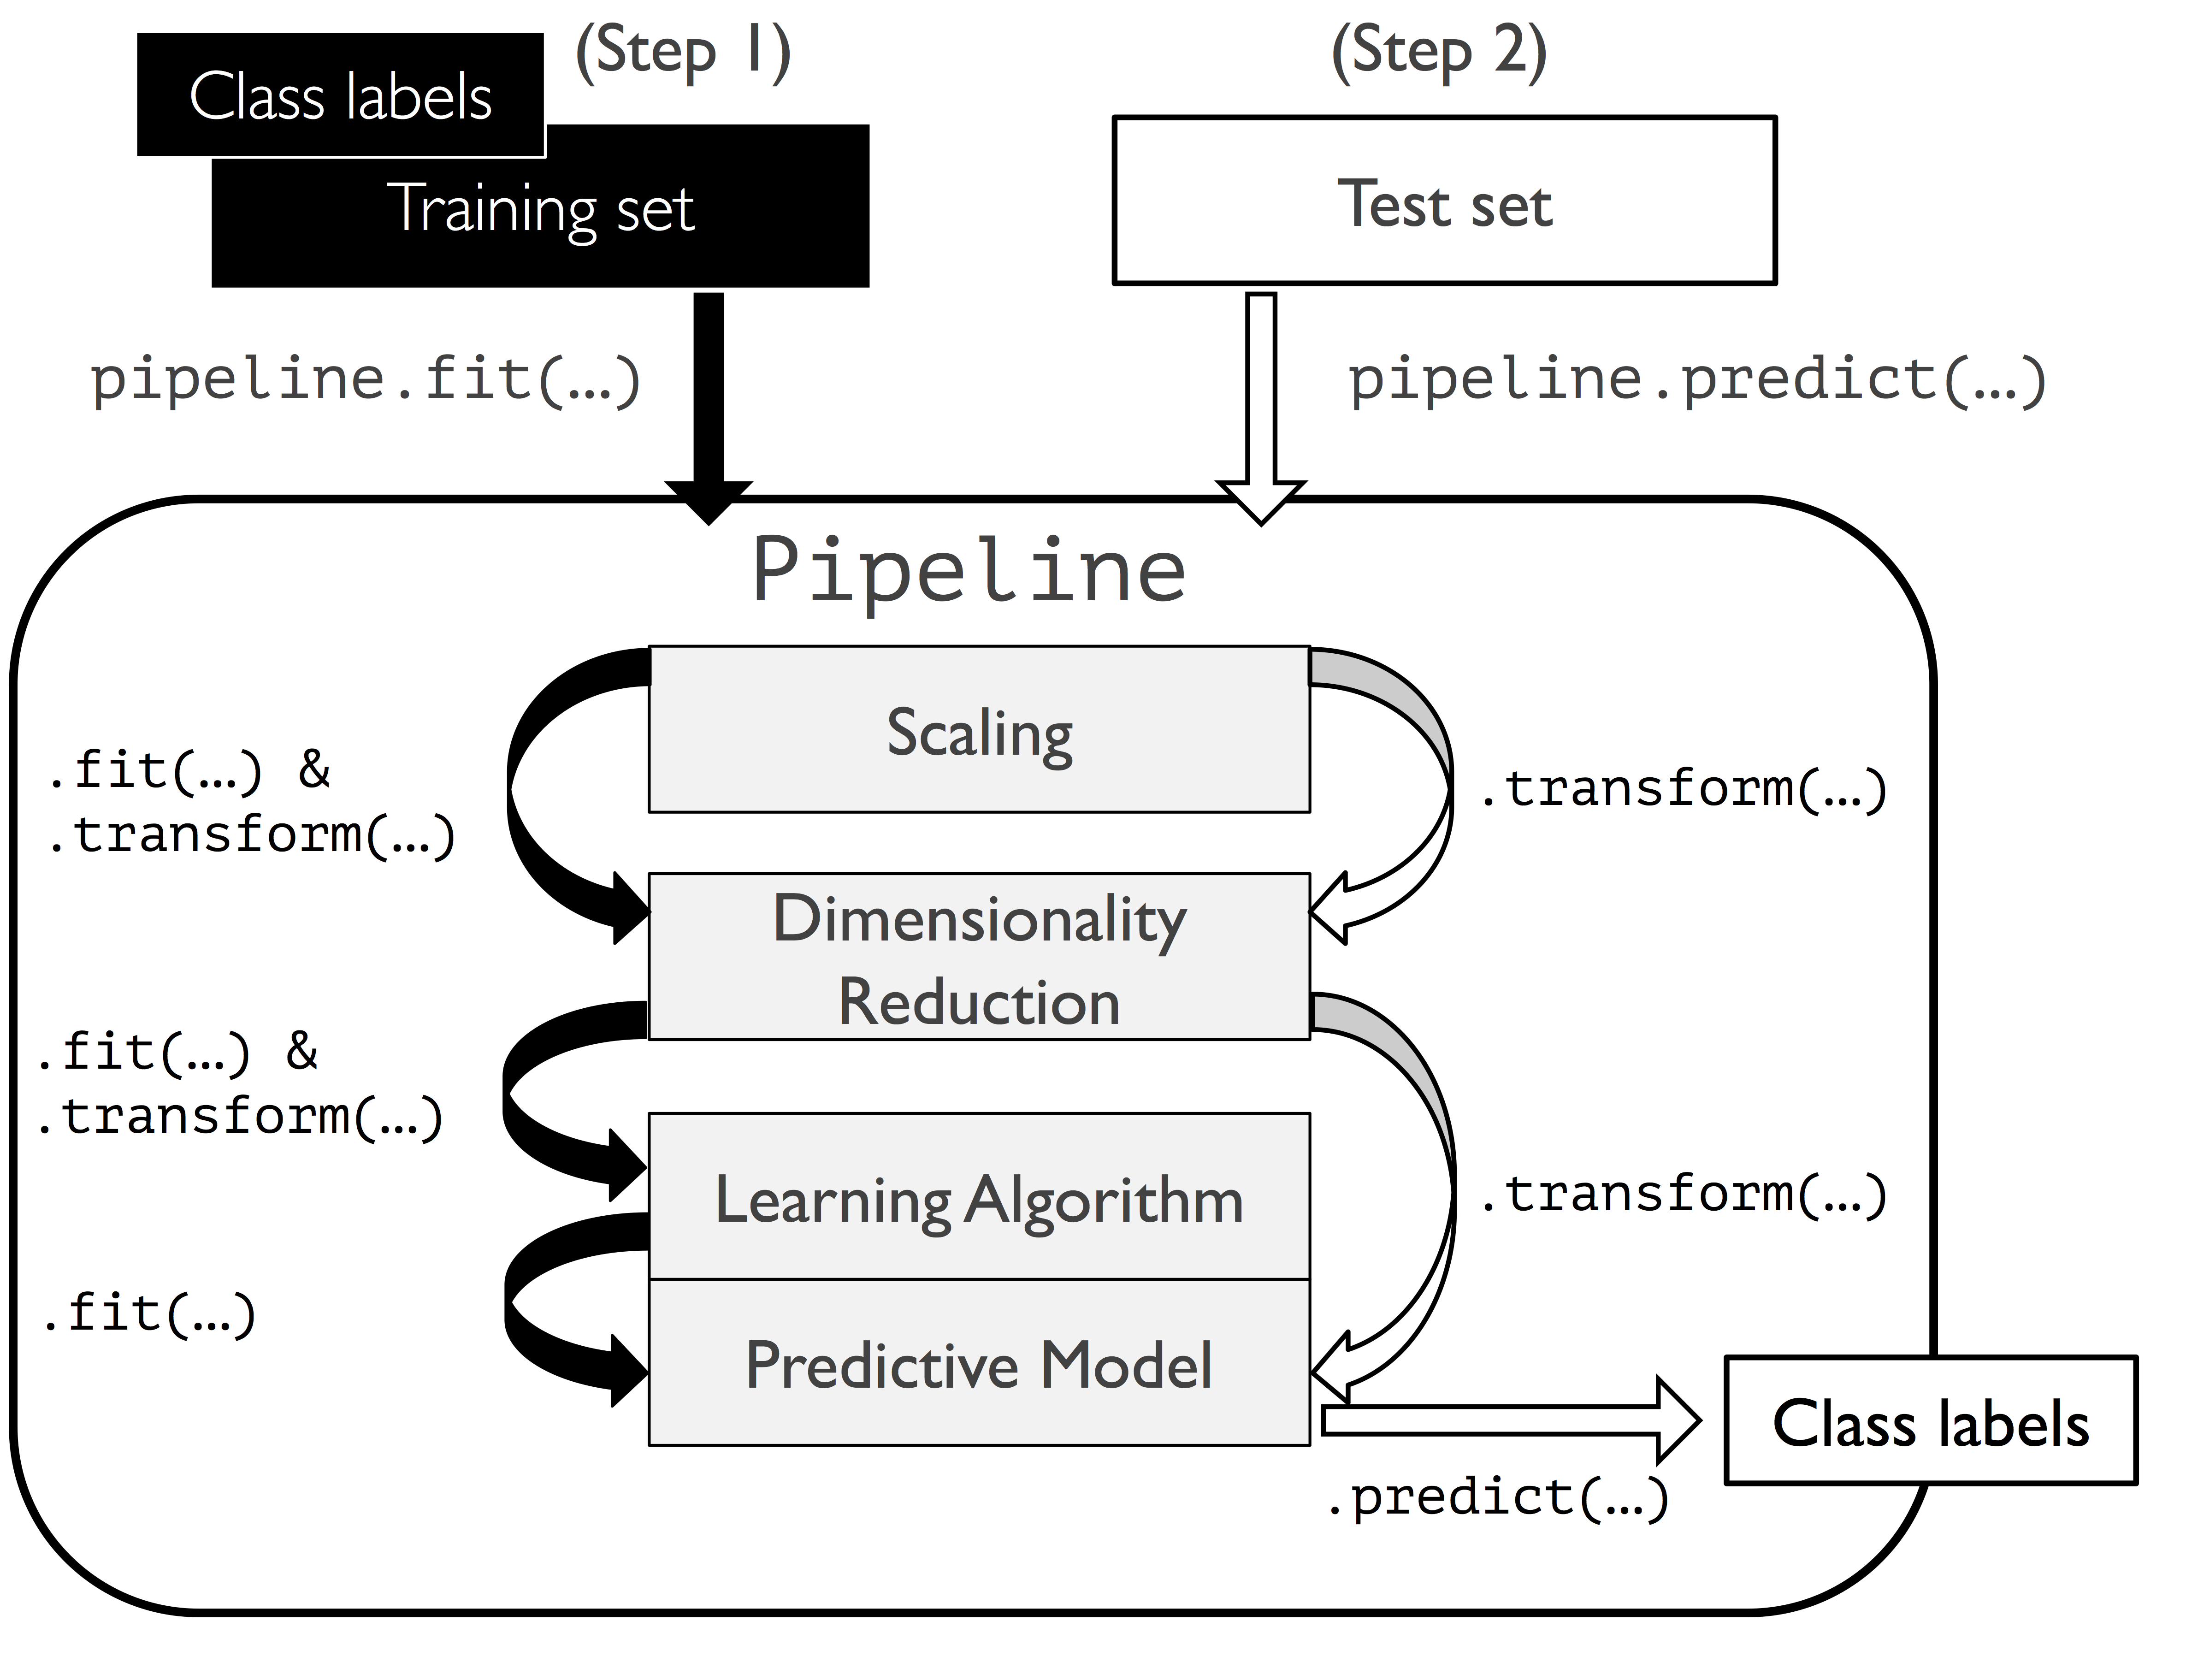

In [4]:
Image(filename='./figures/ch06_1holdout.png', width=500)


### K-fold cross-validation

In [5]:
kfold = StratifiedKFold(n_splits=10, random_state=1).split(X_train, y_train)
scores = []
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print('Fold: %s, Class dist.: %s, Acc: %.3f' %
          (k + 1, np.bincount(y_train[train]), score))
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))


Fold: 1, Class dist.: [256 153], Acc: 0.935
Fold: 2, Class dist.: [256 153], Acc: 0.935


Fold: 3, Class dist.: [256 153], Acc: 0.957


Fold: 4, Class dist.: [256 153], Acc: 0.957
Fold: 5, Class dist.: [256 153], Acc: 0.935


Fold: 6, Class dist.: [257 153], Acc: 0.956
Fold: 7, Class dist.: [257 153], Acc: 0.978
Fold: 8, Class dist.: [257 153], Acc: 0.933
Fold: 9, Class dist.: [257 153], Acc: 0.956
Fold: 10, Class dist.: [257 153], Acc: 0.956
CV accuracy: 0.950 +/- 0.014

In [6]:
scores = cross_val_score(
    estimator=pipe_lr, X=X_train, y=y_train, cv=10, n_jobs=1)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))


CV accuracy scores: [0.93478261 0.93478261 0.95652174 0.95652174 0.93478261 0.95555556
 0.97777778 0.93333333 0.95555556 0.95555556]
CV accuracy: 0.950 +/- 0.014


## Debugging algorithms with learning curves
### Diagnosing bias and variance problems with learning curves

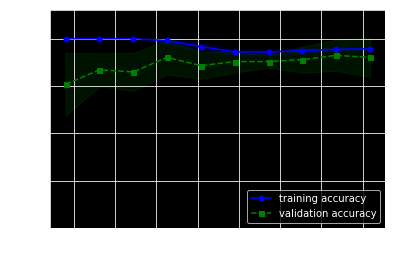

In [7]:
pipe_lr = make_pipeline(
    StandardScaler(),
    LogisticRegression(penalty='l2', random_state=1))#, solver='lbfgs'))
train_sizes, train_scores, test_scores = learning_curve(
    estimator=pipe_lr, X=X_train, y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10), cv=10, n_jobs=1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(train_sizes, train_mean, color='blue', marker='o',
         markersize=5, label='training accuracy')
plt.fill_between(train_sizes, train_mean + train_std,
                 train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s',
         markersize=5, label='validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std,
                 test_mean - test_std, alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
# plt.savefig('figures/ch06_2learning_curve.png', dpi=300)
plt.show()


### Addressing over- and underfitting with validation curves

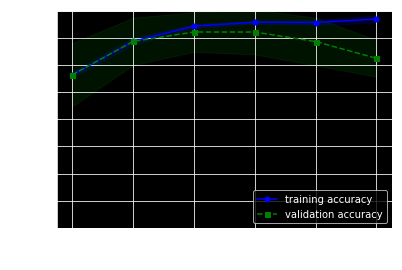

In [8]:
param_range = [10.**i for i in range(-3, 3)]
train_scores, test_scores = validation_curve(
    estimator=pipe_lr, X=X_train, y=y_train,
    param_name='logisticregression__C', param_range=param_range, cv=10)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(param_range, train_mean, color='blue', marker='o',
         markersize=5, label='training accuracy')
plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15, color='blue')
plt.plot(param_range, test_mean, color='green', linestyle='--', marker='s',
         markersize=5, label='validation accuracy')
plt.fill_between(param_range, test_mean + test_std,
                 test_mean - test_std, alpha=0.15, color='green')
plt.grid()
plt.xscale('log')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])
# plt.savefig('figures/ch06_3validation_curve.png', dpi=300)
plt.show()


## Fine-tuning machine learning models via grid search
### Tuning hyperparameters via grid search

In [9]:
pipe_svc = make_pipeline(StandardScaler(), SVC(random_state=1))
param_range = [10.**i for i in range(-4, 4)]
param_grid = [{'svc__C': param_range,
               'svc__kernel': ['linear']},
              {'svc__C': param_range,
               'svc__gamma': param_range,
               'svc__kernel': ['rbf']}]
gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=10,
                  n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)
clf = gs.best_estimator_
clf.fit(X_train, y_train)
print('Test accuracy: %.3f' % clf.score(X_test, y_test))


0.9846153846153847
{'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}
Test accuracy: 0.974


### Algorithm selection with nested cross-validation

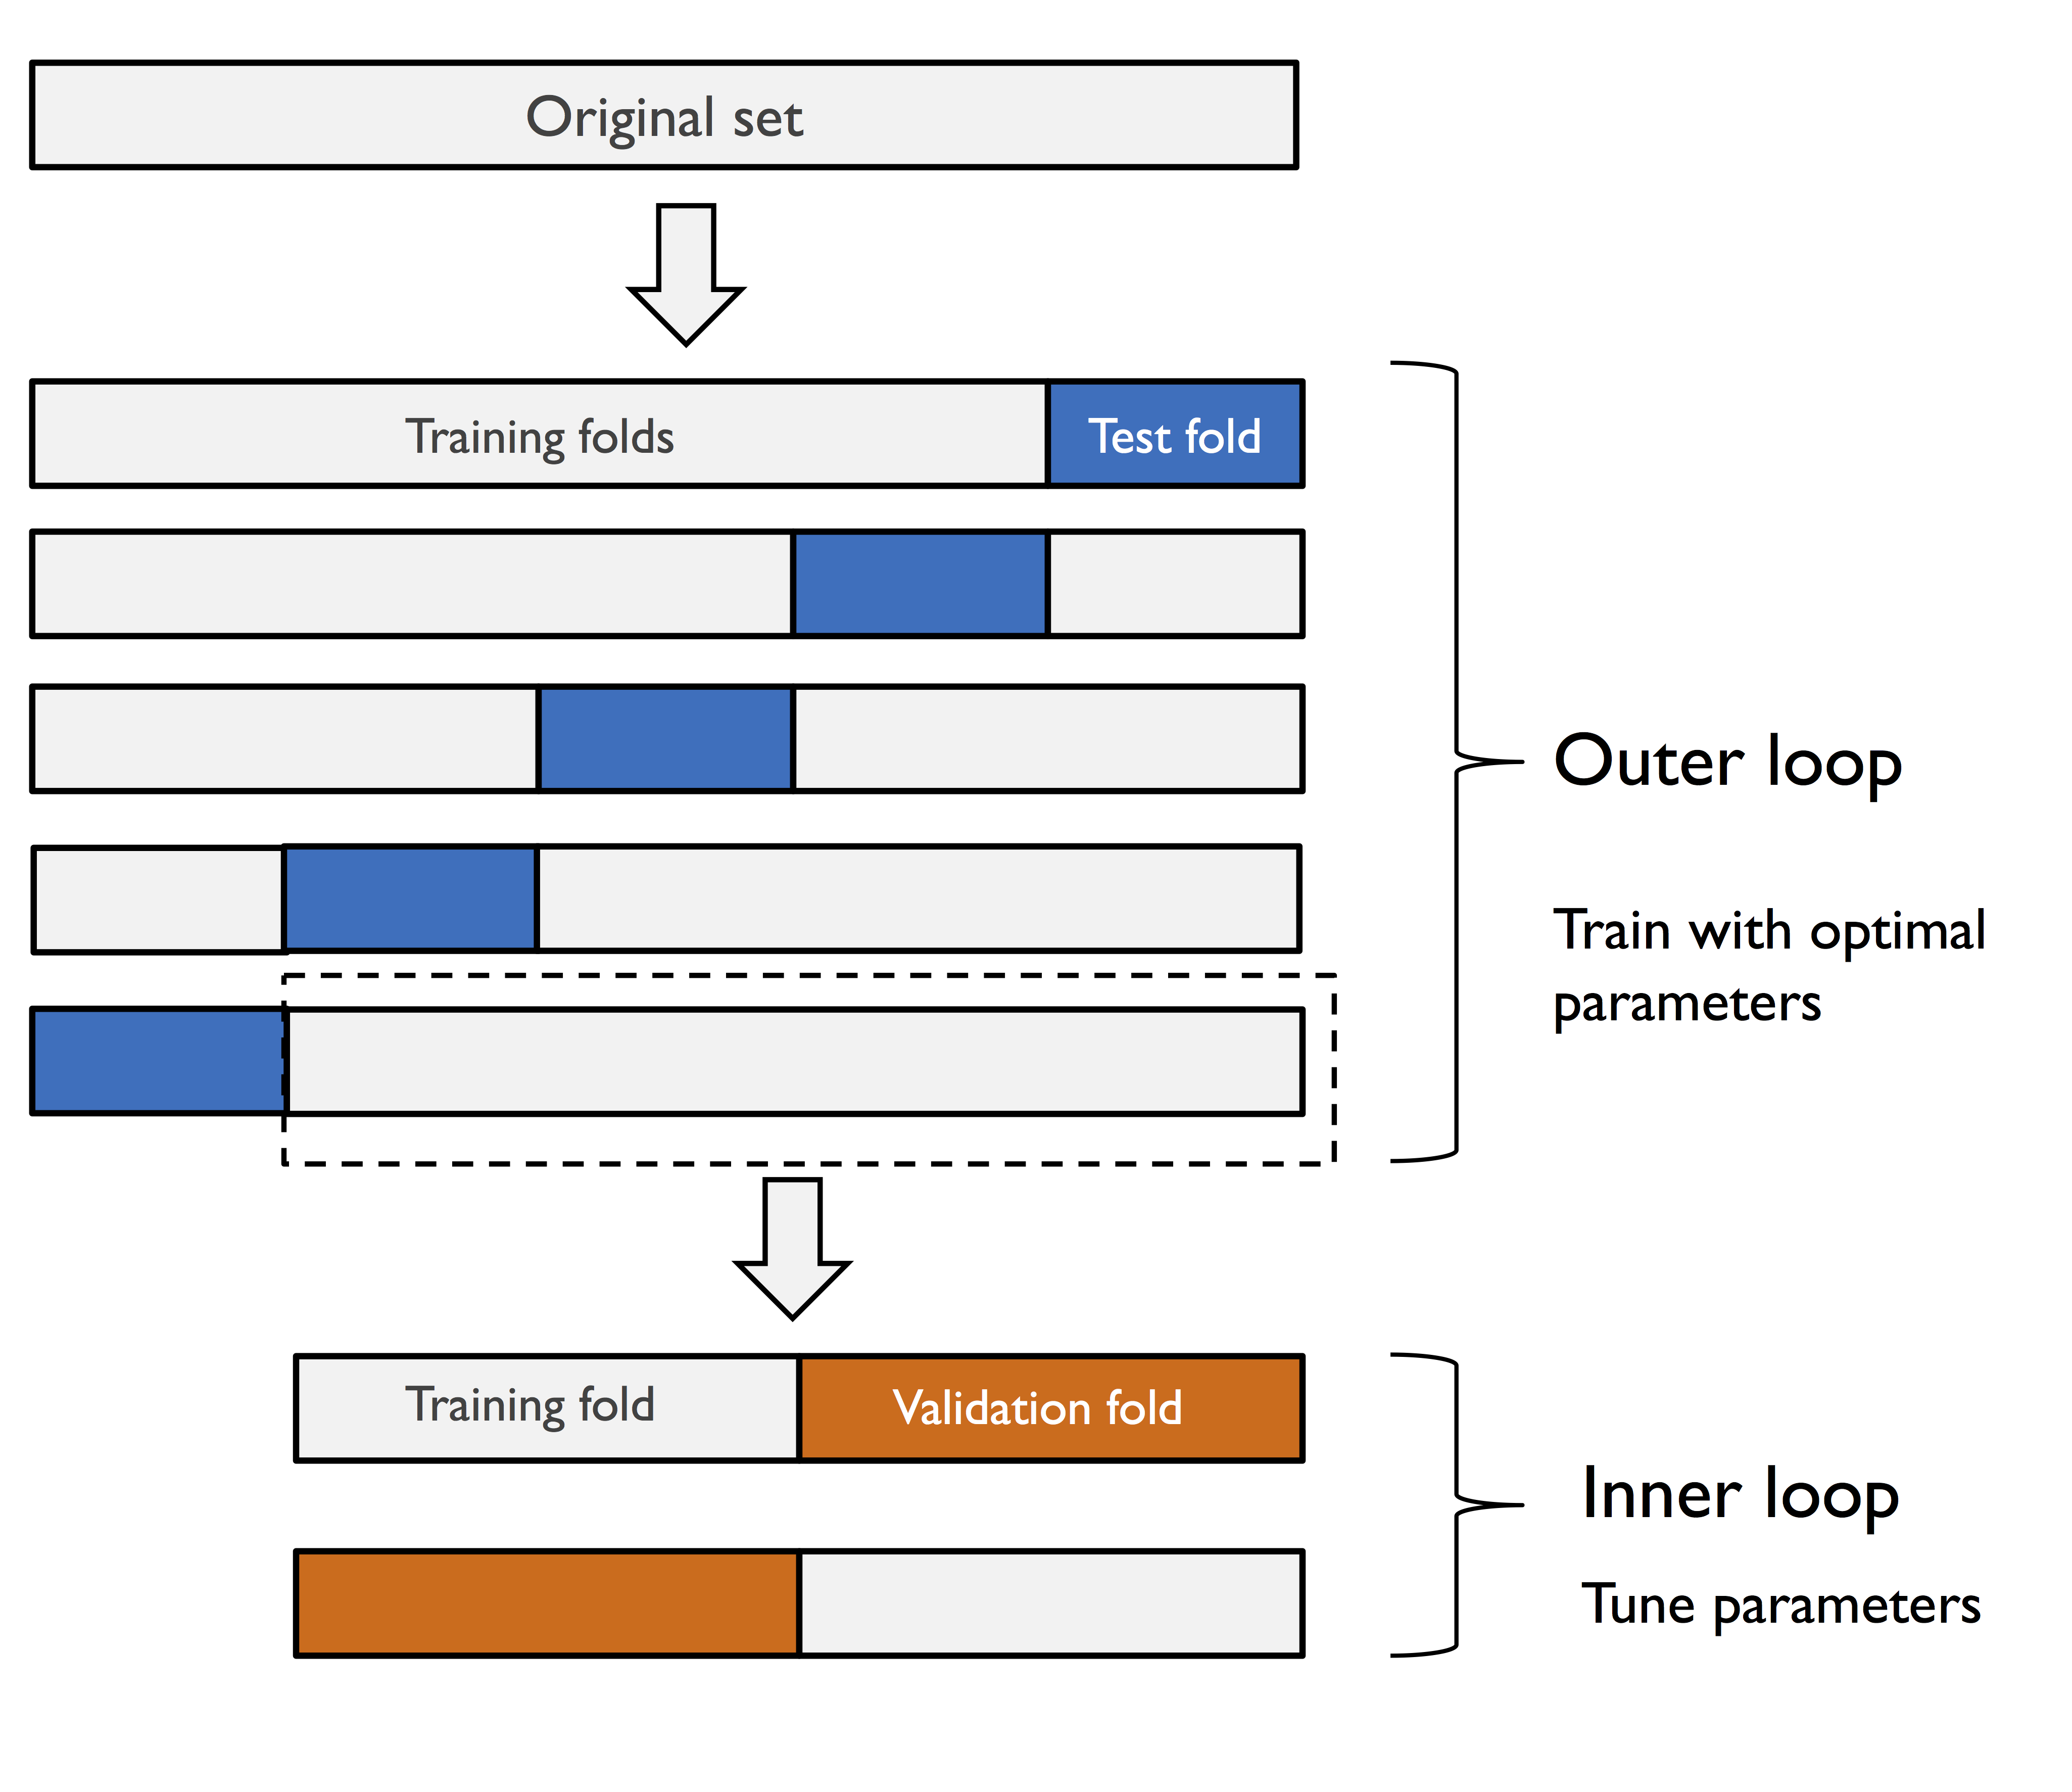

In [10]:
Image(filename='./figures/ch06_4nested_cross_validation.png')


In [11]:
gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=2)
scores = cross_val_score(gs, X_train, y_train, scoring='accuracy', cv=5)
print('svc CV accuracy: %.3f +/- %.3f' %
      (np.mean(scores), np.std(scores)))

gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
                  param_grid=[{'max_depth': [1, 2, 3, 4, 5, 6, 7, None]}],
                  scoring='accuracy',
                  cv=2)
scores = cross_val_score(gs, X_train, y_train, scoring='accuracy', cv=5)
print('svc CV accuracy: %.3f +/- %.3f' %
      (np.mean(scores), np.std(scores)))


svc CV accuracy: 0.974 +/- 0.015


svc CV accuracy: 0.934 +/- 0.016


## Looking at different performance evaluation metrics
### Reading a confusion matrix

[[71  1]
 [ 2 40]]


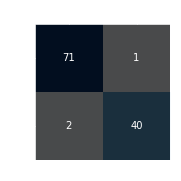

In [12]:
pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()


### Optimizing the precision and recall of a classification model

In [13]:
print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))


Precision: 0.976
Recall: 0.952
F1: 0.964


#### default positive label: 1
#### use make_scorer to change it

In [14]:
scorer = make_scorer(f1_score, pos_label=0)
gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring=scorer,
                  cv=10)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)


0.9880219137963148
{'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


### Plotting a receiver operating characteristic

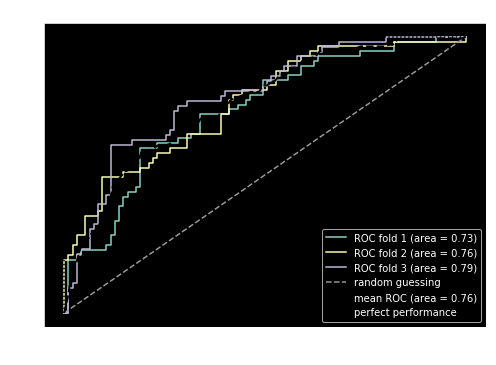

In [15]:
pipe_lr = make_pipeline(
    StandardScaler(),
    PCA(n_components=2),
    LogisticRegression(penalty='l2', random_state=1, C=100.0))
X_train2 = X_train[:, [4, 14]]
cv = list(StratifiedKFold(n_splits=3, random_state=1).split(X_train, y_train))
fig = plt.figure(figsize=(7, 5))
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []
for i, (train, test) in enumerate(cv):
    probas = pipe_lr.fit(
        X_train2[train], y_train[train]).predict_proba(X_train2[test])
    fpr, tpr, thresholds = roc_curve(y_train[test], probas[:, 1], pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='ROC fold %d (area = %0.2f)' % (i+1, roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--',
         color=(0.6, 0.6, 0.6), label='random guessing')
mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='mean ROC (area = %0.2f)' % mean_auc, lw=2)
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':',
         color='black', label='perfect performance')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend(loc="lower right")
plt.tight_layout()
# plt.savefig('figures/ch06_5roc_curve.png', dpi=300)
plt.title('Receiver Operator Characteristic')
plt.show()


In [16]:
pipe_svc = pipe_svc.fit(X_train2, y_train)
y_pred2 = pipe_svc.predict(X_test[:, [4, 14]])
print('ROC AUC: %.3f' % roc_auc_score(y_true=y_test, y_score=y_pred2))
print('Accuracy: %.3f' % accuracy_score(y_true=y_test, y_pred=y_pred2))


ROC AUC: 0.606
Accuracy: 0.684


### The scoring metrics for multiclass classification

In [17]:
pre_scorer = make_scorer(
    score_func=precision_score,
    pos_label=1,
    greater_is_better=True,
    average='micro')


### Dealing with class imbalance

In [18]:
X_imb = np.vstack((X[y == 0], X[y == 1][:40]))
y_imb = np.hstack((y[y == 0], y[y == 1][:40]))
y_pred = np.zeros(y_imb.shape[0])
print(np.mean(y_pred == y_imb) * 100)
print('Number of class 1 samples before:', X_imb[y_imb == 1].shape[0])
X_upsampled, y_upsampled = resample(
    X_imb[y_imb == 1],
    y_imb[y_imb == 1],
    replace=True,
    n_samples=X_imb[y_imb == 0].shape[0],
    random_state=123)
print('Number of class 1 samples after:', X_upsampled.shape[0])
X_bal = np.vstack((X[y == 0], X_upsampled))
y_bal = np.hstack((y[y == 0], y_upsampled))
y_pred = np.zeros(y_bal.shape[0])
np.mean(y_pred == y_bal) * 100


89.92443324937027
Number of class 1 samples before: 40
Number of class 1 samples after: 357


50.0